In [92]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage
import torch

In [93]:
import glob
vec_path = glob.glob("../data/vecs/abo16-an*.pkl")[0]
vec_path

'../data/vecs/abo16-an-02.vec.pkl'

In [94]:
with open(vec_path, "rb") as fin:
    evals = pickle.load(fin)

In [95]:
ans = evals["ans"]
preds = evals["preds"]

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(ans, preds))

              precision    recall  f1-score   support

        Amis       0.97      0.54      0.69       140
      Atayal       0.99      0.84      0.91       192
       Bunun       0.83      0.99      0.90       115
         Cou       0.93      0.99      0.96       154
    Hla'alua       0.94      0.92      0.93        89
  Kanakanavu       1.00      0.93      0.96        95
     Kavalan       0.99      0.98      0.98       145
      Paiwan       0.94      0.97      0.96        35
 Pinuyumayan       0.65      0.98      0.78        54
       Rukai       0.95      0.84      0.89       122
    Sakizaya       0.98      0.96      0.97       155
    Saysiyat       0.78      0.98      0.87       129
      Seediq       0.86      0.78      0.82       102
        Thau       0.87      0.99      0.93       110
       Truku       0.77      0.99      0.86       205
        Yami       1.00      0.93      0.96       215
        misc       0.64      0.57      0.60       219

    accuracy              

In [8]:
import tabulate
clstab = classification_report(ans, preds, output_dict=True)
clstab.pop("accuracy")
clstab.pop("macro avg")
_ = clstab.pop("weighted avg")

In [9]:
col_tabs = {"lang":[], "precision":[], "recall":[], "F1":[], "N":[]}
for k, v in clstab.items():
    col_tabs["lang"].append(k)
    col_tabs["precision"].append(v["precision"])
    col_tabs["recall"].append(v["recall"])
    col_tabs["F1"].append(v["f1-score"])
    col_tabs["N"].append(v["support"])
print(tabulate.tabulate(col_tabs, headers="keys", tablefmt="latex", floatfmt=".2f"))

\begin{tabular}{lrrrr}
\hline
 lang        &   precision &   recall &   F1 &   N \\
\hline
 Amis        &        0.97 &     0.54 & 0.69 & 140 \\
 Atayal      &        0.99 &     0.84 & 0.91 & 192 \\
 Bunun       &        0.83 &     0.99 & 0.90 & 115 \\
 Cou         &        0.93 &     0.99 & 0.96 & 154 \\
 Hla'alua    &        0.94 &     0.92 & 0.93 &  89 \\
 Kanakanavu  &        1.00 &     0.93 & 0.96 &  95 \\
 Kavalan     &        0.99 &     0.98 & 0.98 & 145 \\
 Paiwan      &        0.94 &     0.97 & 0.96 &  35 \\
 Pinuyumayan &        0.65 &     0.98 & 0.78 &  54 \\
 Rukai       &        0.95 &     0.84 & 0.89 & 122 \\
 Sakizaya    &        0.98 &     0.96 & 0.97 & 155 \\
 Saysiyat    &        0.78 &     0.98 & 0.87 & 129 \\
 Seediq      &        0.86 &     0.78 & 0.82 & 102 \\
 Thau        &        0.87 &     0.99 & 0.93 & 110 \\
 Truku       &        0.77 &     0.99 & 0.86 & 205 \\
 Yami        &        1.00 &     0.93 & 0.96 & 215 \\
 misc        &        0.64 &     0.57 & 0.60 

In [10]:
mask = np.array([((x == y) and (x != "misc")) for x, y in zip(ans, preds)])
ans_lst = sorted(set(ans))
ans_lst.remove('misc')
hlast = evals["last"][mask, :]
h0 = evals["h0"][mask, :]
h6 = evals["h6"][mask, :]
ans = np.array(ans)[mask]
preds = np.array(preds)[mask]

In [11]:
len(ans)

1871

## PCA

In [12]:
def plot_proj(hvec, k, dim1=0, dim2=1):
    pca_h = PCA(k)
    h_proj = pca_h.fit_transform(hvec)
    h_norm = h_proj / np.linalg.norm(h_proj, axis=1)[:, np.newaxis]
    ans_idx = [ans_lst.index(x) for x in ans]
    plt.scatter(h_norm[:, dim1], h_norm[:, dim2], c=ans_idx, cmap="tab20")
    plt.xlabel("PCA " + str(dim1+1), size=16)
    plt.ylabel("PCA " + str(dim2+1), size=16)
    return h_norm

['Amis',
 'Atayal',
 'Bunun',
 'Cou',
 "Hla'alua",
 'Kanakanavu',
 'Kavalan',
 'Paiwan',
 'Pinuyumayan',
 'Rukai',
 'Sakizaya',
 'Saysiyat',
 'Seediq',
 'Thau',
 'Truku',
 'Yami']

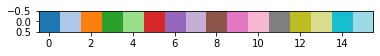

In [13]:
plt.imshow(np.arange(16)[:, np.newaxis].T, cmap="tab20")
ans_lst

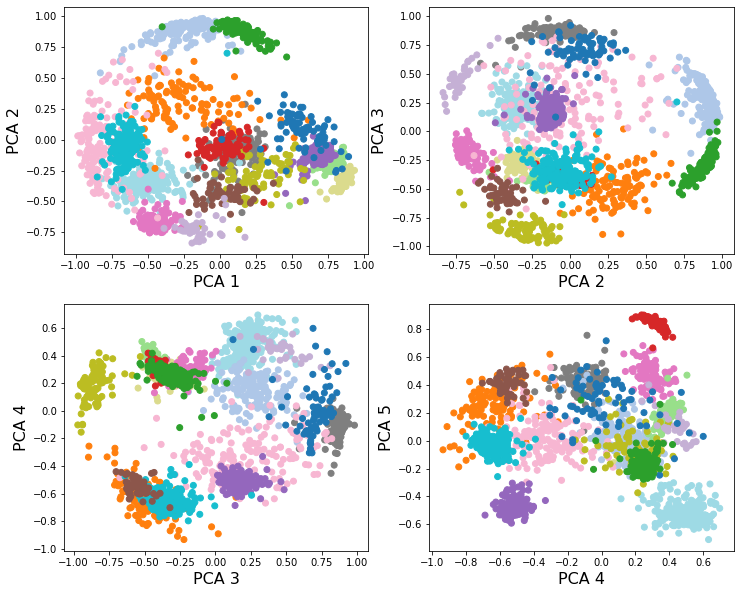

In [14]:
fig = plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
hlast_norm = plot_proj(hlast, 5, 0, 1)
plt.subplot(2, 2, 2)
_ = plot_proj(hlast, 5, 1, 2)
plt.subplot(2, 2, 3)
_ = plot_proj(hlast, 5, 2, 3)
plt.subplot(2, 2, 4)
_ = plot_proj(hlast, 5, 3, 4)
fig.savefig("../data/figure/pca_w2v.png")

In [61]:
def compute_cluster(h_norm):
    medoids = []
    for ans_x in ans_lst:
        mat = h_norm[ans==ans_x]
        D = squareform(pdist(mat, metric='cosine'))
        med_idx = np.argmin(D.sum(axis=0))
        medoids.append(mat[med_idx])   
        
    Dm = pdist(medoids, metric='cosine')
    Zm = linkage(Dm, method='complete')
    
    fig = plt.figure(figsize=(8,6))
    Rm = dendrogram(Zm, labels=ans_lst, leaf_rotation=45, link_color_func=lambda x: "black")        
    xlabels = plt.gca().get_xticklabels()
    _ = plt.gca().set_xticklabels(xlabels, ha='right', size=16)
    plt.title("Clustering with speech vectors", size=20)
    fig.subplots_adjust(bottom=0.2)
    fig.savefig("../data/figure/w2v_cluster.png")
    return medoids, Dm, Rm

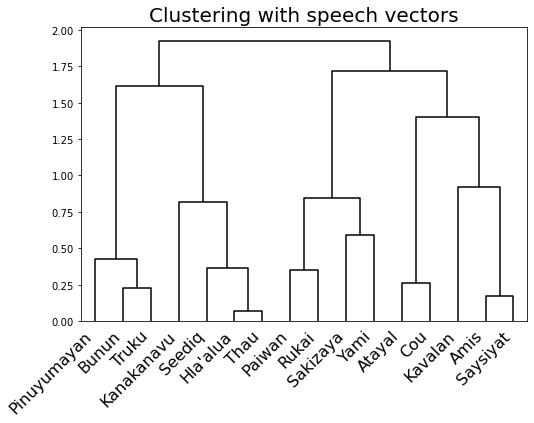

In [62]:
medoids_last, dm, rm = compute_cluster(hlast_norm)

In [63]:
def plot_medoids_dist(medoids, Dm ,Rm):
    plt.figure(figsize=(8, 6))
    plt.imshow(squareform(Dm)[Rm["leaves"], :][:, Rm["leaves"]], cmap="summer_r")
    plt.gca().set_xticks(np.arange(0, len(ans_lst)))
    lang_labels = [ans_lst[x] for x in Rm["leaves"]]
    plt.gca().set_xticklabels(lang_labels, rotation=45, ha="right", size=16)
    plt.gca().set_yticks(np.arange(0, len(ans_lst)))
    _ = plt.gca().set_yticklabels(lang_labels, size=16)
    plt.title("Distance between medoids", size=20)
    
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    cax = plt.axes([0.85, 0.1, 0.075, 0.8])
    plt.colorbar(cax=cax)
    

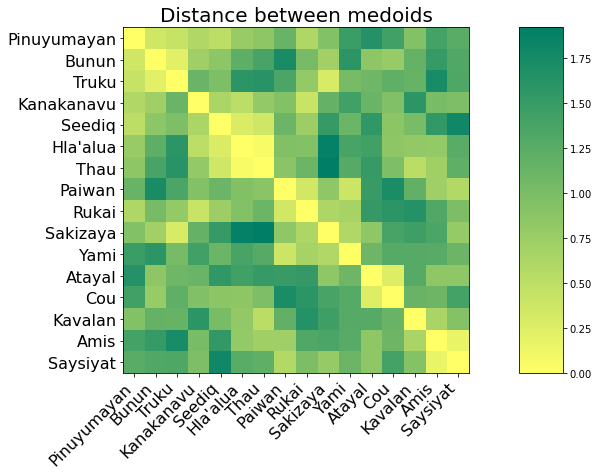

In [64]:
plot_medoids_dist(medoids_last, dm, rm)

## Linguistic features

In [65]:
with open("../data/abo16.tsv", "r") as fin:
    abo16_map = {}
    for ln in fin.readlines()[1:]:
        toks = ln.strip().split("\t")
        if len(toks) < 2: continue
        abo16_map[toks[1]] = toks[0]
        if len(toks) >= 3:
            abo16_map[toks[2]] = toks[0]

In [66]:
# load dummy dataframe and transpose it
feat_dummy = pd.read_csv("../data/langfeats/formosan_dummies.csv").transpose()
feat_dummy.columns = feat_dummy.iloc[0, :]
feat_dummy.drop("Feature", axis=0, inplace=True)
feat_dummy.columns.names = [None]
# map language names with abo16
feat_dummy.index = [abo16_map.get(x, None) for x in feat_dummy.index.values]
feat_dummy = feat_dummy.iloc[[ans_lst.index(x) for x in feat_dummy.index]]

In [88]:
lang_corr = feat_dummy.transpose().astype(np.float32).corr("kendall").values

In [89]:
svec_corr = 1-squareform(dm)

In [90]:
np.corrcoef(lang_corr.ravel(), svec_corr.ravel())

array([[1.        , 0.37628092],
       [0.37628092, 1.        ]])

## Compute training statistics

In [96]:
import json
with open("../data/abo16_an_splits.json", "r") as fin:
    splits = json.load(fin)

In [97]:
from collections import Counter
Counter([x[1] for x in splits["train"]]).most_common()

[('Yami', 8),
 ('Rukai', 8),
 ('Sakizaya', 8),
 ('Pinuyumayan', 8),
 ('Saysiyat', 7),
 ('Thau', 7),
 ('misc', 7),
 ("Hla'alua", 7),
 ('Bunun', 7),
 ('Kavalan', 7),
 ('Seediq', 7),
 ('Kanakanavu', 7),
 ('Truku', 7),
 ('Amis', 7),
 ('Cou', 7),
 ('Atayal', 6),
 ('Paiwan', 5)]

In [98]:
len(splits["train"])

120

In [99]:
Counter([x[1] for x in splits["test"]]).most_common()

[('Saysiyat', 1),
 ('Thau', 1),
 ('Yami', 1),
 ('Atayal', 1),
 ('misc', 1),
 ('Rukai', 1),
 ("Hla'alua", 1),
 ('Bunun', 1),
 ('Sakizaya', 1),
 ('Kavalan', 1),
 ('Seediq', 1),
 ('Kanakanavu', 1),
 ('Truku', 1),
 ('Pinuyumayan', 1),
 ('Paiwan', 1),
 ('Amis', 1),
 ('Cou', 1)]

In [100]:
lang_minutes = {}
for _, lang, pcm_len in splits["train"]:
    lang_minutes[lang] = lang_minutes.get(lang, 0) +  pcm_len/16000/60
for _, lang, pcm_len in splits["test"]:
    lang_minutes[lang] = lang_minutes.get(lang, 0) +  pcm_len/16000/60

In [101]:
lang_minutes

{'Saysiyat': 43.0,
 'Thau': 44.25,
 'Yami': 47.25,
 'Atayal': 41.0,
 'misc': 54.416666666666664,
 'Rukai': 42.83333333333334,
 "Hla'alua": 34.833333333333336,
 'Bunun': 52.666666666666664,
 'Sakizaya': 54.5,
 'Kavalan': 59.333333333333336,
 'Seediq': 47.0,
 'Kanakanavu': 37.083333333333336,
 'Truku': 73.5,
 'Pinuyumayan': 40.916666666666664,
 'Paiwan': 12.333333333333332,
 'Amis': 35.83333333333333,
 'Cou': 69.83333333333333}

In [102]:
sum(lang_minutes.values())

790.5833333333334